In [2]:
%pip install -q langchain_community langchain_anthropic langchain_tavily langgraph


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
from dotenv import load_dotenv

load_dotenv()

True

In [25]:
# llm 설정
from langchain_anthropic import ChatAnthropic

llm = ChatAnthropic(model="claude-3-7-sonnet-latest", max_tokens=8000)
small_llm = ChatAnthropic(model="claude-3-5-haiku-latest", max_tokens=4000)

In [ ]:
from typing import Literal
from langchain_core.messages import HumanMessage, AIMessage
from langchain_tavily import TavilySearch
from langgraph.graph import MessagesState
from langchain.agents import create_agent
from langgraph.types import Command

tavliy_search_tool = TavilySearch(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
)

research_agent = create_agent(
    model=llm,
    tools=[tavliy_search_tool.as_tool()],
    system_prompt= """당신은 세계적인 수준의 여행 연구 전문가입니다. 여행 목적지와 사용자가 여행하고자 하는 일수가 주어지면, 
관련 여행 활동 및 숙박시설을 찾기 위한 검색어 목록을 생성하세요.
그런 다음 각 검색어로 웹을 검색하고, 결과를 분석하여 가장 관련성 높은 결과 10개를 반환하세요.

작업 순서:
1. 여행 목적지와 일수와 관련된 검색어 3개를 생성하세요
2. 각 검색어에 대해 tavily_search를 실행하고 결과를 분석하세요
3. 모든 검색 결과에서 사용자의 선호도에 가장 관련성 높은 결과 10개를 요약하여 반환하세요
4. 결과의 품질이 중요합니다. 간결하고 핵심적인 정보만 제공하세요.
"""
)

def research_agent_node(state: MessagesState) -> Command[Literal['planner_agent_node']] :
    result = research_agent.invoke(state)
    last_message = result['messages'][-1].content
    return Command(
        goto='planner_agent_node', 
        update={'messages': [HumanMessage(last_message, name='research_agent_node')]}
    )

In [ ]:
from typing import Literal
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessagesState
from langchain.agents import create_agent
from langgraph.types import Command

planner_agent = create_agent(
    model=llm,
    system_prompt= """당신은 시니어 여행 플래너입니다. 여행 목적지, 여행 기간, 조사한 정보를 바탕으로
사용자 맞춤형 여행 일정을 작성합니다.

# 작성 방법
- 조사한 정보를 활용해 추천 활동과 숙박시설이 포함된 일정 초안 작성
- 체계적이고 유익하며 매력적인 구성
- 구체적인 정보 인용으로 균형잡힌 일정 제공
- 명확성, 일관성, 완성도에 집중
- 정보 지어내기 금지, 출처 명확히 표기

# 중요
일정의 품질이 가장 중요합니다.
"""
)

def planner_agent_node(state: MessagesState) -> Command[Literal[END]] :
    result = planner_agent.invoke(state)
    last_message = result['messages'][-1].content
    return Command(
        goto=END, 
        update={'messages': [HumanMessage(last_message, name='planner_agent_node')]}
    )

In [28]:
from langgraph.graph import START, StateGraph


graph_builder = StateGraph(MessagesState)

graph_builder.add_node('research_agent_node', research_agent_node)
graph_builder.add_node('planner_agent_node', planner_agent_node)

graph_builder.add_edge(START, 'research_agent_node')
graph_builder.add_edge('research_agent_node', 'planner_agent_node')
graph_builder.add_edge('planner_agent_node', END)

graph = graph_builder.compile()

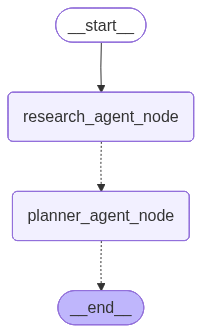

In [29]:
graph

In [ ]:
initial_state = MessagesState(messages=[HumanMessage(content="나는 12월 22일부터 24일까지 제주도 여행을 가려고 해 여행 일정을 작성해주세요")])

for chunk in graph.stream(
    initial_state, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

나는 12월 22일부터 24일까지 제주도 여행을 가려고 해 여행 일정을 작성해주세요
